In [10]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import spearmanr

import sys
sys.path.append('./analysis/')

%load_ext autoreload
%autoreload 2
import utils

from utils import domain_to_abbreviated_name, is_industry_domain, is_academic_domain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
lm_metadata = utils.load_annotated_lm_metadata()

## Counts

In [12]:
# Print counts of each affiliation type
print("Number of tracked academic affilations:", len(utils.academic_domains))
print("Number of tracked industry affilations:", len(utils.industry_domains))

# Print counts of: (1) has any affiliation; (2) academic only; (3) industry only; (4) both (5) no affil
print("Any listed domain:", lm_metadata.domains.apply(lambda x: len(x) > 0).sum(),
        "({:.1f}%)".format(100 * lm_metadata.domains.apply(lambda x: len(x) > 0).sum() / len(lm_metadata)))
print("Any affiliation with >=10 papers:", len(lm_metadata[(lm_metadata.academic) | (lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(lm_metadata.academic) | (lm_metadata.industry)]) / len(lm_metadata)))
print(">= 1 academic:", len(lm_metadata[(lm_metadata.academic)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(lm_metadata.academic)]) / len(lm_metadata)))
print(">= 1 industry:", len(lm_metadata[(lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(lm_metadata.industry)]) / len(lm_metadata)))
print("Academic only:", len(lm_metadata[(lm_metadata.academic) & (~lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(lm_metadata.academic) & (~lm_metadata.industry)]) / len(lm_metadata)))
print("Industry only:", len(lm_metadata[(~lm_metadata.academic) & (lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(~lm_metadata.academic) & (lm_metadata.industry)]) / len(lm_metadata)))
print("Industry-academic:", len(lm_metadata[(lm_metadata.academic) & (lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(lm_metadata.academic) & (lm_metadata.industry)]) / len(lm_metadata)))
print("No affiliation:", len(lm_metadata[(~lm_metadata.academic) & (~lm_metadata.industry)]),
        "({:.1f}%)".format(100 * len(lm_metadata[(~lm_metadata.academic) & (~lm_metadata.industry)]) / len(lm_metadata)))

Number of tracked academic affilations: 280
Number of tracked industry affilations: 41
Any listed domain: 14179 (83.5%)
Any affiliation with >=10 papers: 11688 (68.8%)
>= 1 academic: 10002 (58.9%)
>= 1 industry: 3774 (22.2%)
Academic only: 7914 (46.6%)
Industry only: 1686 (9.9%)
Industry-academic: 2088 (12.3%)
No affiliation: 5291 (31.2%)


In [13]:
# domain_count_df = utils.get_domain_counts_with_affiliation_type(lm_metadata)
# domain_count_df_above_10 = domain_count_df[domain_count_df['count'] >= 10]

# print("Number of tracked academic affilations:", (domain_count_df_above_10['affiliation_type'] == 'academic').sum())
# print("Number of tracked industry affilations:", (domain_count_df_above_10['affiliation_type'] == 'industry').sum())
# print("Number of tracked other affilations:", (domain_count_df_above_10['affiliation_type'] == 'other').sum())

academic_academic_counter = 0
academic_industry_counter = 0
industry_industry_counter = 0

for row in lm_metadata['domains']:
    count_academic = sum([is_academic_domain(x) for x in row])
    count_industry = sum([is_industry_domain(x) for x in row])
    if count_academic >= 2:
        academic_academic_counter += 1
    if count_academic >= 1 and count_industry >= 1:
        academic_industry_counter += 1
    if count_industry >= 2:
        industry_industry_counter += 1
            
print(academic_academic_counter, '# papers with two different academic institutions')
print(academic_industry_counter, '# papers with at least one academic and one industry institution')
print(industry_industry_counter, '# papers with two different industry institutions')

2267 # papers with two different academic institutions
2088 # papers with at least one academic and one industry institution
104 # papers with two different industry institutions


In [14]:
# Plot percent of papers with an academic affiliation, industry affiliation, or both by year

affiliation_counts = {'year': [], 'total': [], 'academic': [], 'industry': [], 'both': []}
for year in range(2018, 2024):
    year_df = lm_metadata[(lm_metadata['v1_date'].dt.year == year) & (lm_metadata['industry'] | lm_metadata['academic'])]
    affiliation_counts['year'].append(year)
    affiliation_counts['total'].append(len(year_df))
    affiliation_counts['academic'].append((year_df['academic']).sum())
    affiliation_counts['industry'].append((year_df['industry']).sum())
    affiliation_counts['both'].append(((year_df['academic']) & (year_df['industry'])).sum())

affiliation_counts_df = pd.DataFrame(affiliation_counts)
affiliation_counts_df['academic_frac'] = affiliation_counts_df['academic'] / affiliation_counts_df['total']
affiliation_counts_df['industry_frac'] = affiliation_counts_df['industry'] / affiliation_counts_df['total']
affiliation_counts_df['both_frac'] = affiliation_counts_df['both'] / affiliation_counts_df['total']
display(affiliation_counts_df)

# Also print academic_frac, industry_frac, and both_frac for the entire range of 2018-22
print("Academic fraction 2018-22:", "{:.3f}".format(affiliation_counts_df.iloc[:5]['academic'].sum() / affiliation_counts_df.iloc[:5]['total'].sum()))
print("Industry fraction 2018-22:", "{:.3f}".format(affiliation_counts_df.iloc[:5]['industry'].sum() / affiliation_counts_df.iloc[:5]['total'].sum()))
print("Both fraction 2018-22:", "{:.3f}".format(affiliation_counts_df.iloc[:5]['both'].sum() / affiliation_counts_df.iloc[:5]['total'].sum()))

# # Lineplots with markers and 95% CIs using standard error
# plt.figure(figsize=(4, 3), dpi=200)
# plt.plot(affiliation_counts_df['year'], affiliation_counts_df['academic_frac'], label='Academic', marker='o')
# plt.fill_between(affiliation_counts_df['year'], affiliation_counts_df['academic_frac'] - 1.96 * np.sqrt(affiliation_counts_df['academic_frac'] * (1 - affiliation_counts_df['academic_frac']) / affiliation_counts_df['total']), affiliation_counts_df['academic_frac'] + 1.96 * np.sqrt(affiliation_counts_df['academic_frac'] * (1 - affiliation_counts_df['academic_frac']) / affiliation_counts_df['total']), alpha=0.2)
# plt.plot(affiliation_counts_df['year'], affiliation_counts_df['industry_frac'], label='Industry', marker='o')
# plt.fill_between(affiliation_counts_df['year'], affiliation_counts_df['industry_frac'] - 1.96 * np.sqrt(affiliation_counts_df['industry_frac'] * (1 - affiliation_counts_df['industry_frac']) / affiliation_counts_df['total']), affiliation_counts_df['industry_frac'] + 1.96 * np.sqrt(affiliation_counts_df['industry_frac'] * (1 - affiliation_counts_df['industry_frac']) / affiliation_counts_df['total']), alpha=0.2)
# plt.plot(affiliation_counts_df['year'], affiliation_counts_df['both_frac'], label='Both', marker='o')
# plt.fill_between(affiliation_counts_df['year'], affiliation_counts_df['both_frac'] - 1.96 * np.sqrt(affiliation_counts_df['both_frac'] * (1 - affiliation_counts_df['both_frac']) / affiliation_counts_df['total']), affiliation_counts_df['both_frac'] + 1.96 * np.sqrt(affiliation_counts_df['both_frac'] * (1 - affiliation_counts_df['both_frac']) / affiliation_counts_df['total']), alpha=0.2)

# plt.ylabel('Number of papers')
# plt.xlabel('Year')
# plt.legend()
# plt.tight_layout()
# plt.show()


,year,total,academic,industry,both,academic_frac,industry_frac,both_frac
0,2018,235,189,84,38,0.804,0.357,0.162
1,2019,776,620,323,167,0.799,0.416,0.215
2,2020,1538,1257,563,282,0.817,0.366,0.183
3,2021,2062,1741,698,377,0.844,0.339,0.183
4,2022,2802,2389,974,561,0.853,0.348,0.200
5,2023,4275,3806,1132,663,0.890,0.265,0.155


Academic fraction 2018-22: 0.836
Industry fraction 2018-22: 0.356
Both fraction 2018-22: 0.192


In [15]:
# Print papers with 'openai.com' in domains list
display(lm_metadata[lm_metadata.domains.apply(lambda x: 'openai.com' in x)].sample(5))

,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,cluster,domains,industry,academic,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window
1008,arXiv:1909.08593,"[Daniel M. Ziegler, Nisan Stiennon, Jeffrey Wu...",Fine-Tuning Language Models from Human Prefere...,"[cs.CL, cs.LG, stat.ML]",Reward learning enables the application of r...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 201...",cs.CL,2019-09-18 17:33:39,[language model],True,Human Feedback & Interaction,[openai.com],True,False,408.000,0.928,0.928
5362,arXiv:2109.00110,"[Kunhao Zheng, Jesse Michael Han, Stanislas Polu]",MiniF2F: a cross-system benchmark for formal O...,"[cs.AI, cs.FL, cs.LG]","We present miniF2F, a dataset of formal Olym...","[{'version': 'v1', 'created': 'Tue, 31 Aug 202...",cs.AI,2021-08-31 23:21:12,[GPT-3],True,"LLMs, Reasoning, Chain-of-Thought","[openai.com, polytechnique.edu]",True,False,22.000,0.794,0.761
2597,arXiv:2009.03393,"[Stanislas Polu, Ilya Sutskever]",Generative Language Modeling for Automated The...,"[cs.LG, cs.AI, cs.CL, stat.ML]",We explore the application of transformer-ba...,"[{'version': 'v1', 'created': 'Mon, 7 Sep 2020...",cs.LG,2020-09-07 19:50:10,[language model],True,"LLMs, Reasoning, Chain-of-Thought",[openai.com],True,False,138.000,0.934,0.928
4915,arXiv:2106.10328,"[Irene Solaiman, Christy Dennison]",Process for Adapting Language Models to Societ...,"[cs.CL, cs.CY]",Language models can generate harmful and bia...,"[{'version': 'v1', 'created': 'Fri, 18 Jun 202...",cs.CL,2021-06-18 19:38:28,"[language model, GPT-3]",True,Toxicity & Hate Speech,[openai.com],True,False,124.000,0.950,0.957
8142,arXiv:2206.05802,"[William Saunders, Catherine Yeh, Jeff Wu, Ste...",Self-critiquing models for assisting human eva...,"[cs.CL, cs.LG]",We fine-tune large language models to write ...,"[{'version': 'v1', 'created': 'Sun, 12 Jun 202...",cs.CL,2022-06-12 17:40:53,"[language model, large language model]",True,Human Feedback & Interaction,[openai.com],True,False,57.000,0.952,0.956


## Most prolific institutions

In [16]:
domain_count_df = utils.get_domain_counts_with_affiliation_type(lm_metadata)
# Change allenai.org 'affiliation_type' to non-profit
domain_count_df.loc[domain_count_df['domain'] == 'allenai.org', 'affiliation_type'] = 'non-profit'
domain_count_df

,domain,count,affiliation_type
0,microsoft.com,729,industry
1,google.com,654,industry
2,cmu.edu,359,academic
3,tsinghua.edu.cn,332,academic
4,stanford.edu,324,academic
...,...,...,...
3183,ict.jvn.edu.vn,1,other
3184,rtl.nl,1,other
3185,lloydsbanking.com,1,other
3186,biba.uni-bremen.de,1,other


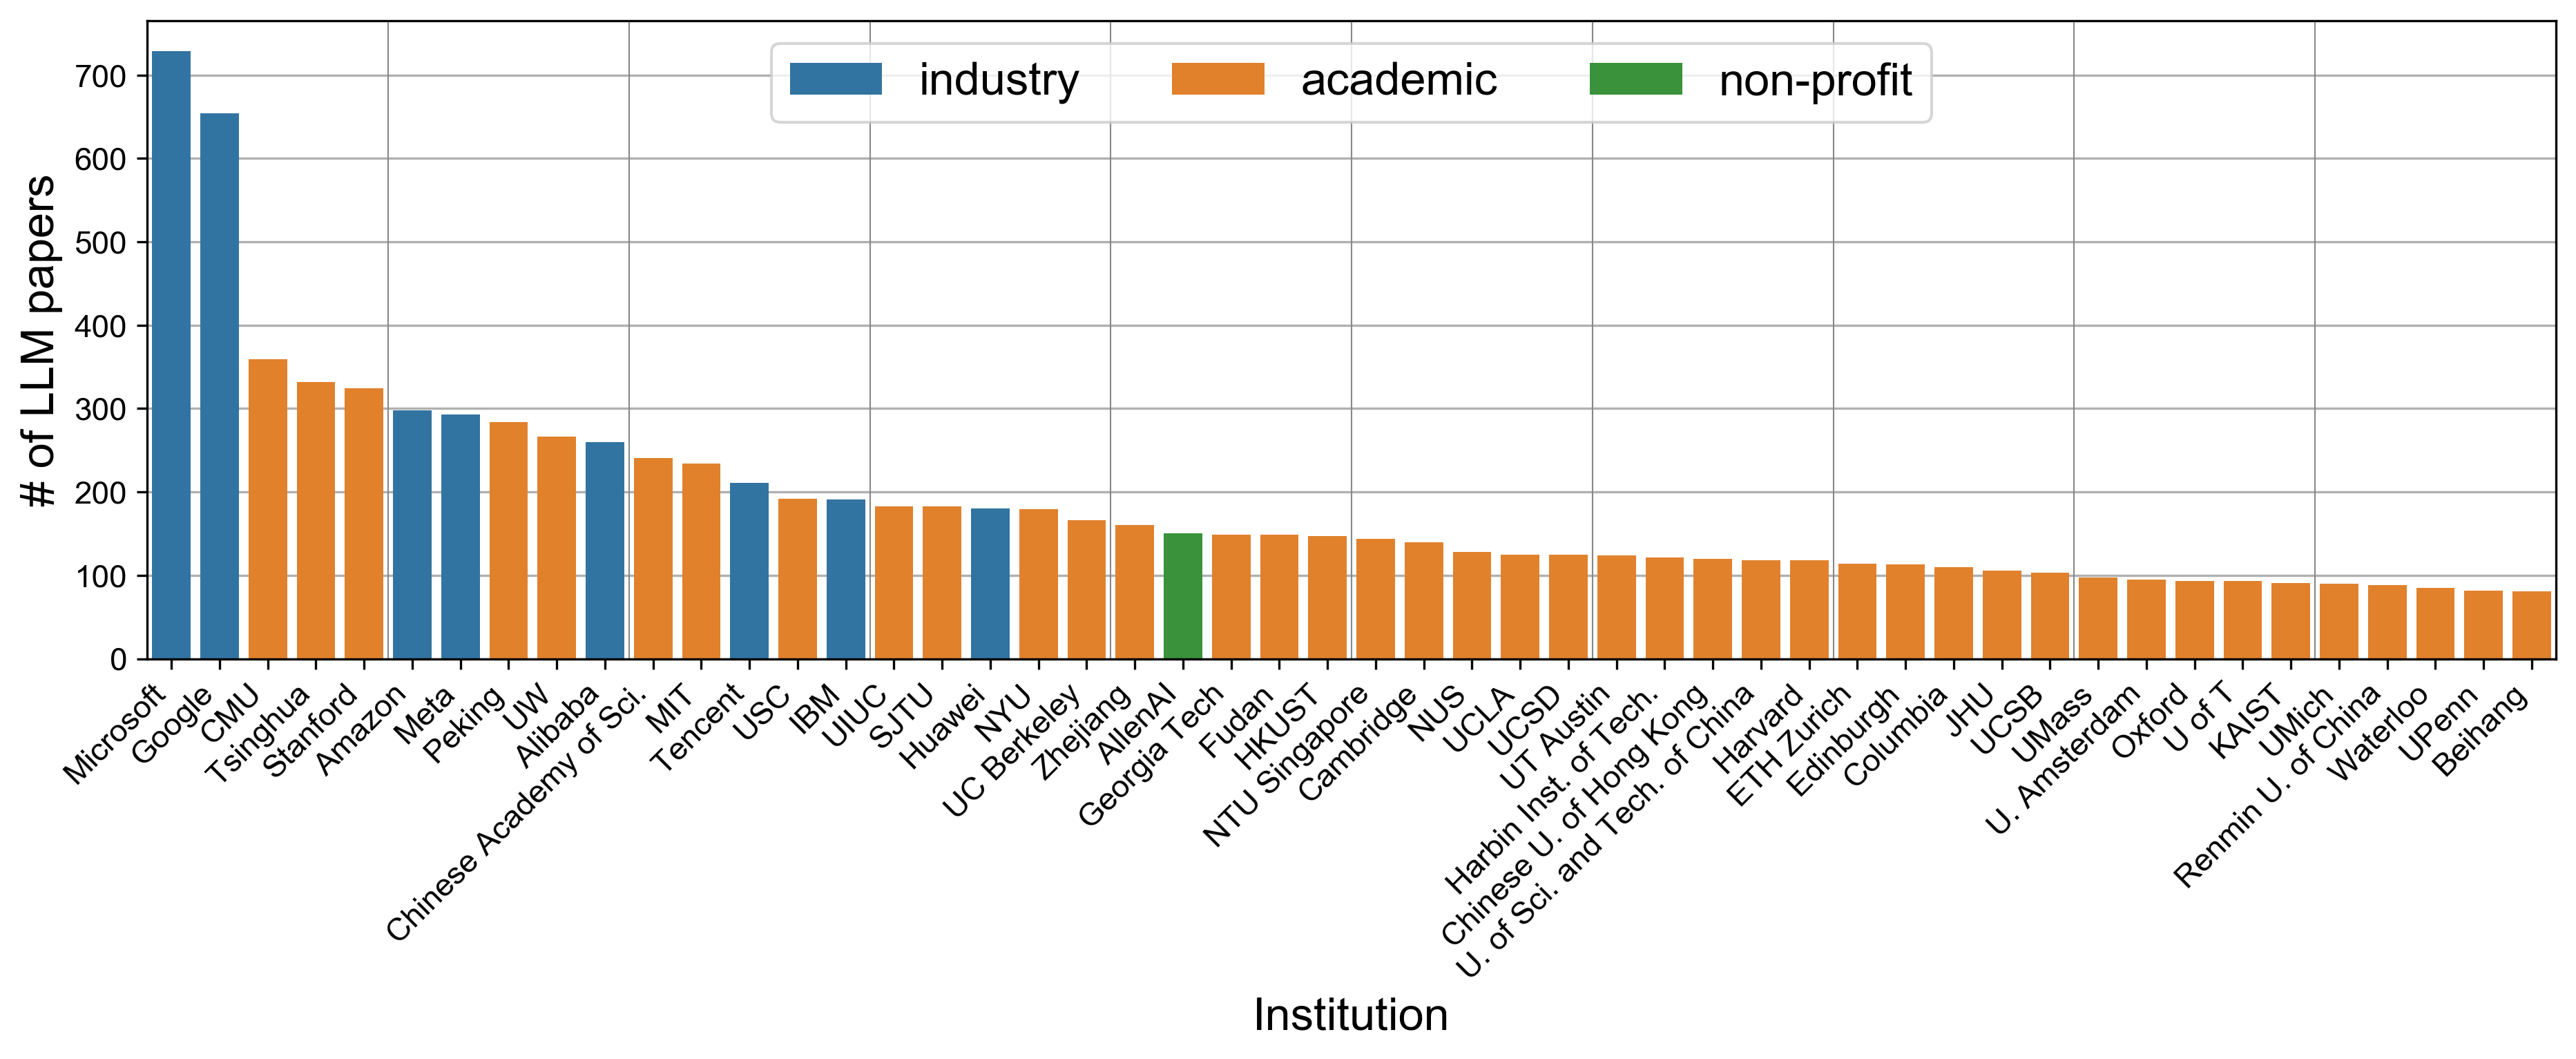

In [17]:
plt.figure(figsize=(15, 4), dpi=300)
n_plot = 50
ax = sns.barplot(x='domain', y='count', data=domain_count_df.head(n_plot), hue='affiliation_type', dodge=False)

# Map existing domains to ticklabels using domain_to_abbreviated_name
ax.set(xticklabels=[domain_to_abbreviated_name[domain] for domain in domain_count_df.head(50)['domain']])
plt.setp(ax.get_xticklabels(), fontsize=11)
plt.setp(ax.get_yticklabels(), fontsize=11)

plt.grid(axis='y') # Grid lines, only for y-axis
ax.set_axisbelow(True) # Places grid lines are behind the bars
plt.ylabel('# of LLM papers', fontsize=16)
plt.xlabel('Institution', fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.legend(
           loc='upper center', 
           bbox_to_anchor=(0.5, 1),
           ncol=3, 
           fontsize=16, 
          )

# plt.axvline every 5
for i in range(0, 50, 5):
    plt.axvline(i - 0.5, color='#888888', linewidth=0.5)

plt.savefig('./analysis/figures/affiliation_barplot.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()

## Prolific institutions vs. citation counts

In [18]:
top_domains = domain_count_df[domain_count_df['count'] >= 20].copy()

def get_papers_with_domain(domain):
    return lm_metadata[lm_metadata['domains'].apply(lambda domain_list: domain in domain_list)]

top_domains['total_citations'] = top_domains['domain'].apply(lambda domain: get_papers_with_domain(domain).citationCount.sum())
top_domains['median_citations'] = top_domains['domain'].apply(lambda domain: get_papers_with_domain(domain).citationCount.median())
top_domains['median_citation_percentile'] = top_domains['domain'].apply(lambda domain: get_papers_with_domain(domain).percentile_rank_in_3_month_window.median())
top_domains['mean_citation_percentile'] = top_domains['domain'].apply(lambda domain: get_papers_with_domain(domain).percentile_rank_in_3_month_window.mean())
top_domains['count_above_100_citations'] = top_domains['domain'].apply(lambda domain: len(get_papers_with_domain(domain)[get_papers_with_domain(domain).citationCount >= 100]))
top_domains['count_in_top_citation_decile'] = top_domains['domain'].apply(lambda domain: len(get_papers_with_domain(domain)[get_papers_with_domain(domain).percentile_rank_in_3_month_window >= 0.9]))

top_domains['count_rank'] = top_domains['count'].rank(ascending=False, method='min')
top_domains['total_citations_rank'] = top_domains['total_citations'].rank(ascending=False, method='min')
top_domains['median_citations_rank'] = top_domains['median_citations'].rank(ascending=False, method='min')
top_domains['count_above_100_citations_rank'] = top_domains['count_above_100_citations'].rank(ascending=False, method='min')
top_domains['count_in_top_citation_decile_rank'] = top_domains['count_in_top_citation_decile'].rank(ascending=False, method='min')

display(top_domains.head())

,domain,count,affiliation_type,total_citations,median_citations,median_citation_percentile,mean_citation_percentile,count_above_100_citations,count_in_top_citation_decile,count_rank,total_citations_rank,median_citations_rank,count_above_100_citations_rank,count_in_top_citation_decile_rank
0,microsoft.com,729,industry,36918.000,8.000,0.653,0.611,76,118,1.000,4.000,19.000,2.000,2.000
1,google.com,654,industry,130970.000,14.000,0.732,0.659,116,150,2.000,1.000,7.000,1.000,1.000
2,cmu.edu,359,academic,27547.000,7.000,0.605,0.589,38,64,3.000,5.000,32.000,4.000,5.000
3,tsinghua.edu.cn,332,academic,9539.000,3.000,0.568,0.556,23,33,4.000,8.000,116.000,8.000,9.000
4,stanford.edu,324,academic,14707.000,9.000,0.684,0.627,33,72,5.000,7.000,13.000,5.000,4.000


In [19]:
print_domains = ['allenai.org', 'deepmind.com', 'openai.com', 'ttic.edu', 'princeton.edu', 'cornell.edu']
display(top_domains[top_domains['domain'].isin(print_domains)])

,domain,count,affiliation_type,total_citations,median_citations,median_citation_percentile,mean_citation_percentile,count_above_100_citations,count_in_top_citation_decile,count_rank,total_citations_rank,median_citations_rank,count_above_100_citations_rank,count_in_top_citation_decile_rank
21,allenai.org,150,non-profit,24747.000,17.000,0.722,0.660,27,34,22.000,6.000,4.000,7.000,8.000
50,princeton.edu,80,academic,5662.000,5.000,0.599,0.596,6,14,51.000,16.000,50.000,31.000,26.000
52,cornell.edu,79,academic,4095.000,6.000,0.580,0.565,5,7,53.000,21.000,38.000,35.000,57.000
91,deepmind.com,46,industry,5107.000,31.500,0.911,0.808,11,24,88.000,18.000,2.000,15.000,15.000
119,ttic.edu,34,academic,5205.000,7.000,0.620,0.586,4,4,120.000,17.000,32.000,44.000,78.000
191,openai.com,21,industry,7515.000,116.000,0.955,0.898,11,15,189.000,11.000,1.000,15.000,22.000


In [20]:
# cornell = lm_metadata[lm_metadata['domains'].apply(lambda domain_list: 'cornell.edu' in domain_list)]
# display(cornell.sort_values(by='citationCount', ascending=False).head(5))

princeton = lm_metadata[lm_metadata['domains'].apply(lambda domain_list: 'princeton.edu' in domain_list)]
display(princeton.sort_values(by='citationCount', ascending=False).head(5))

ttic = lm_metadata[lm_metadata['domains'].apply(lambda domain_list: 'ttic.edu' in domain_list)]
display(ttic.sort_values(by='citationCount', ascending=False).head(5))

,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,cluster,domains,industry,academic,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window
4341,arXiv:2104.08821,"[Tianyu Gao, Xingcheng Yao, Danqi Chen]",SimCSE: Simple Contrastive Learning of Sentenc...,"[cs.CL, cs.LG]","This paper presents SimCSE, a simple contras...","[{'version': 'v1', 'created': 'Sun, 18 Apr 202...",cs.CL,2021-04-18 11:27:08,[BERT],True,"Representations, Syntax, Semantics","[princeton.edu, tsinghua.edu.cn]",False,True,1450.000,0.998,0.997
754,arXiv:1907.10529,"[Mandar Joshi, Danqi Chen, Yinhan Liu, Daniel ...",SpanBERT: Improving Pre-training by Representi...,"[cs.CL, cs.LG]","We present SpanBERT, a pre-training method t...","[{'version': 'v1', 'created': 'Wed, 24 Jul 201...",cs.CL,2019-07-24 15:43:40,[BERT],True,"Representations, Syntax, Semantics","[princeton.edu, washington.edu, fb.com]",True,True,1430.000,0.981,0.978
3575,arXiv:2012.15723,"[Tianyu Gao, Adam Fisch, Danqi Chen]",Making Pre-trained Language Models Better Few-...,"[cs.CL, cs.LG]","The recent GPT-3 model (Brown et al., 2020) ...","[{'version': 'v1', 'created': 'Thu, 31 Dec 202...",cs.CL,2020-12-31 17:21:26,"[language model, GPT-3]",True,Prompts & In-Context Learning,"[princeton.edu, mit.edu]",False,True,989.000,0.999,0.991
474,arXiv:1904.05342,"[Kexin Huang, Jaan Altosaar, Rajesh Ranganath]",ClinicalBERT: Modeling Clinical Notes and Pred...,"[cs.CL, cs.LG]",Clinical notes contain information about pat...,"[{'version': 'v1', 'created': 'Wed, 10 Apr 201...",cs.CL,2019-04-10 17:53:13,[BERT],True,NLP for Healthcare,"[princeton.edu, nyu.edu]",False,True,499.000,0.903,0.939
4188,arXiv:2104.05240,"[Zexuan Zhong, Dan Friedman, Danqi Chen]",Factual Probing Is [MASK]: Learning vs. Learni...,[cs.CL],Petroni et al. (2019) demonstrated that it i...,"[{'version': 'v1', 'created': 'Mon, 12 Apr 202...",cs.CL,2021-04-12 07:11:40,[language model],True,Prompts & In-Context Learning,[princeton.edu],False,True,218.000,0.974,0.978


,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,cluster,domains,industry,academic,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window
1054,arXiv:1909.11942,"[Zhenzhong Lan, Mingda Chen, Sebastian Goodman...",ALBERT: A Lite BERT for Self-supervised Learni...,"[cs.CL, cs.AI]",Increasing model size when pretraining natur...,"[{'version': 'v1', 'created': 'Thu, 26 Sep 201...",cs.CL,2019-09-26 07:06:13,[BERT],True,Efficiency & Performance,"[ttic.edu, google.com]",True,True,4478.000,0.992,0.992
154,arXiv:1807.10857,"[Shubham Toshniwal, Anjuli Kannan, Chung-Cheng...",A Comparison of Techniques for Language Model ...,"[eess.AS, cs.AI, cs.CL, cs.SD]",Attention-based recurrent neural encoder-dec...,"[{'version': 'v1', 'created': 'Fri, 27 Jul 201...",eess.AS,2018-07-27 23:33:33,[language model],True,Speech Recognition,"[ttic.edu, google.com]",True,True,132.000,0.896,0.846
2363,arXiv:2007.06778,"[Lifu Tu, Garima Lalwani, Spandana Gella, He He]",An Empirical Study on Robustness to Spurious C...,"[cs.CL, cs.LG]",Recent work has shown that pre-trained langu...,"[{'version': 'v1', 'created': 'Tue, 14 Jul 202...",cs.CL,2020-07-14 02:34:59,"[language model, BERT]",True,Fine-Tuning & Domain Adaptation,"[ttic.edu, amazon.com, nyu.edu]",True,True,125.000,0.926,0.919
6598,arXiv:2201.02184,"[Bowen Shi, Wei-Ning Hsu, Kushal Lakhotia, Abd...",Learning Audio-Visual Speech Representation by...,"[eess.AS, cs.CV, cs.SD]",Video recordings of speech contain correlate...,"[{'version': 'v1', 'created': 'Wed, 5 Jan 2022...",eess.AS,2022-01-05 17:40:45,[BERT],True,Speech Recognition,"[ttic.edu, fb.com]",True,True,101.000,0.963,0.978
30,arXiv:1803.03376,"[Lifu Tu, Kevin Gimpel]",Learning Approximate Inference Networks for St...,"[cs.CL, cs.LG, stat.ML]",Structured prediction energy networks (SPENs...,"[{'version': 'v1', 'created': 'Fri, 9 Mar 2018...",cs.CL,2018-03-09 03:50:24,[language model],True,Efficiency & Performance,[ttic.edu],False,True,48.000,0.583,0.675


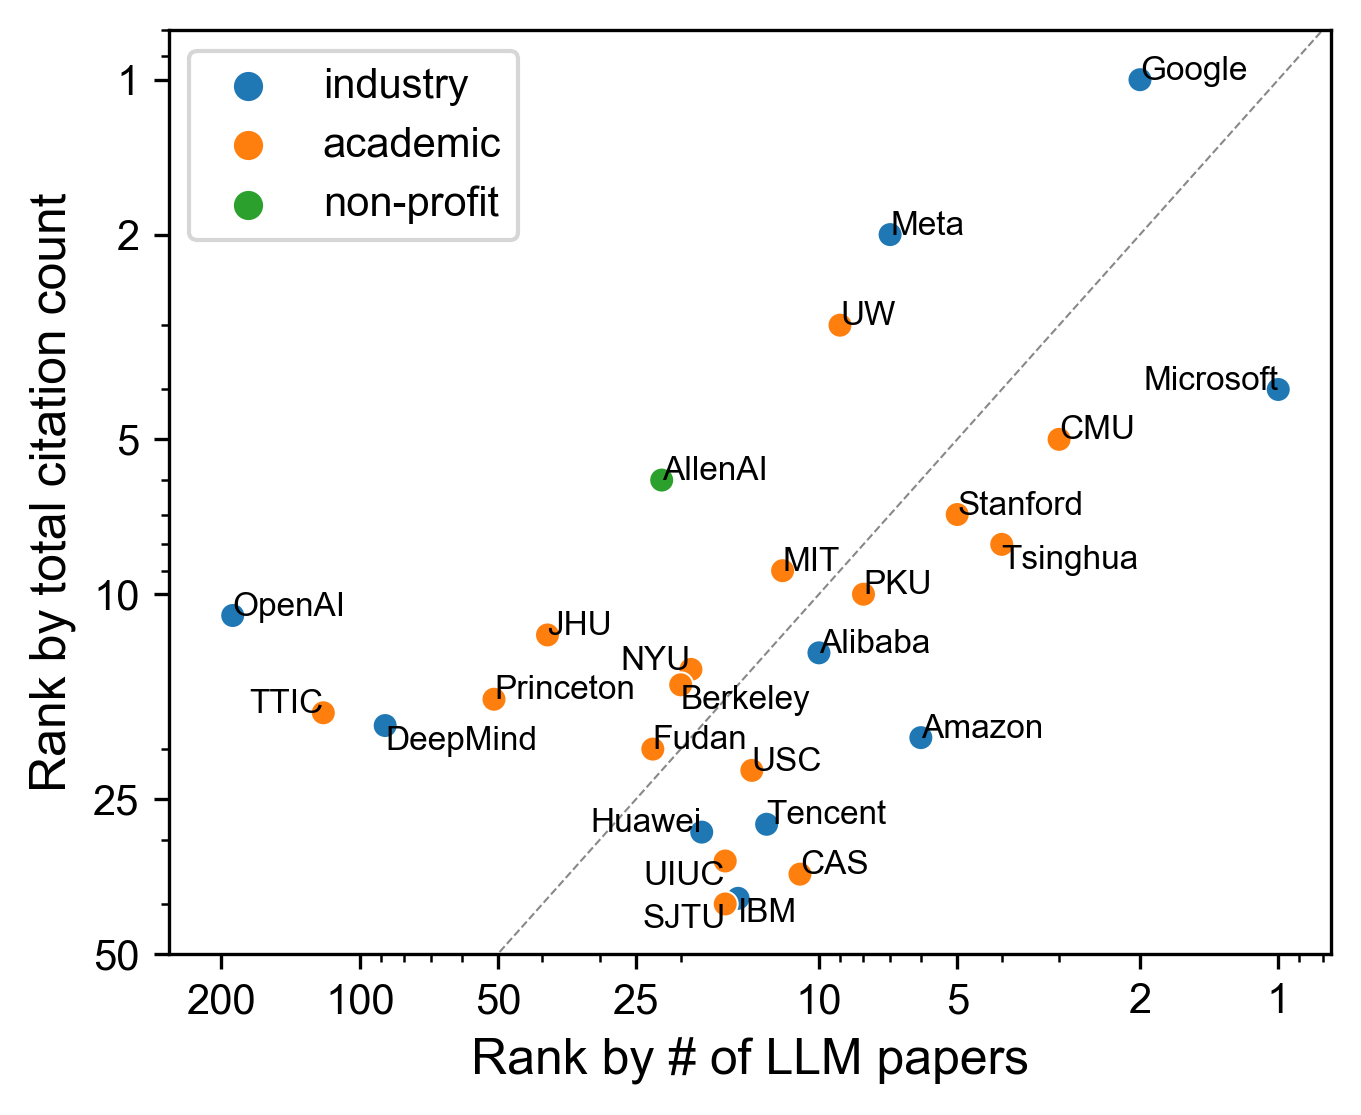

In [21]:
from utils import domain_to_abbreviated_name, domain_to_very_short

# Plot 'count_rank' vs 'total_citations_rank' on a scatterplot for institutions that are in the top 25 for either

top_k = 20

xaxis_col = 'count_rank'
yaxis_col = 'total_citations_rank'
# yaxis_col = 'count_in_top_citation_decile_rank'
# yaxis_col = 'count_above_100_citations_rank'

institutions_to_include = set(top_domains[top_domains[xaxis_col] <= top_k].domain)
institutions_to_include.update(set(top_domains[top_domains[yaxis_col] <= top_k].domain))

plot_df = top_domains[top_domains.domain.isin(institutions_to_include)].copy()

plt.figure(figsize=(5, 4), dpi=300)

ax = sns.scatterplot(x=xaxis_col, y=yaxis_col, data=plot_df, hue='affiliation_type')

# # Label each point
# # Adjustments for readability - this is for the count in top decile rank
# align_left = ['USTC', 'NTU', 'HKUST', 'Alibaba', 'NYU', 'UIUC', 'Salesforce', 'AllenAI']
# align_bottom = ['HKUST', 'USC', 'Tencent', 'AllenAI']
# # Adjustments for readability - this is for total citation count
align_left = ['TTIC', 'SJTU', 'Huawei', 'NYU', 'UIUC', 'Microsoft']
align_bottom = ['Tsinghua', 'IBM', 'SJTU', 'Berkeley', 'UIUC', 'DeepMind']
for i, row in plot_df.iterrows():
    abbrev = domain_to_very_short[row['domain']]
    ha = 'left'
    va = 'baseline'
    if abbrev in align_left:
        ha = 'right'
    if abbrev in align_bottom:
        va = 'top'
    if abbrev == 'HKUST':
        ha = 'center'
    # xcoord, ycoord = row[xaxis_col], row[yaxis_col]
    # if abbrev == 'USTC':
    #     xcoord -= 1
    #     ycoord -= 1
    ax.text(row[xaxis_col], row[yaxis_col], abbrev, fontsize=8, ha=ha, va=va)

# # Draw a best fit line to see how points are distributed wrt the average pattern
# sns.regplot(x=xaxis_col, y=yaxis_col, data=plot_df, scatter=False, ax=ax)
# Draw y = x line
plt.plot([0, 200], 
         [0, 200], 
         color='#888888', linewidth=0.5, linestyle='--')

# Axes should be on log scale, but ticklabels should be on linear scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set ticklabels to be linear, add more tick labels
ax.set_xticks([1, 2, 5, 10, 25, 50, 100, 200])
ax.set_xticklabels([1, 2, 5, 10, 25, 50, 100, 200])
ax.set_yticks([1, 2, 5, 10, 25, 50, 100, 200])
ax.set_yticklabels([1, 2, 5, 10, 25, 50, 100, 200])

# Reverse axes so that lower ranks are up and to the right
ax.set_ylim([0.8, 50])
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])

# Set axis labels
plt.xlabel('Rank by # of LLM papers', fontsize=12)
# plt.ylabel('Rank by # of papers in top 10% of citations', fontsize=12)
plt.ylabel('Rank by total citation count', fontsize=12)

plt.legend(fontsize=10)

# plt.savefig('./analysis/figures/affiliation_count_vs_totalcites_scatterplot.pdf', bbox_inches='tight')
plt.show()

In [22]:
display(top_domains.sort_values(by='mean_citation_percentile', ascending=False).head(10))
print(spearmanr(top_domains['median_citation_percentile'], top_domains['mean_citation_percentile']))

,domain,count,affiliation_type,total_citations,median_citations,median_citation_percentile,mean_citation_percentile,count_above_100_citations,count_in_top_citation_decile,count_rank,total_citations_rank,median_citations_rank,count_above_100_citations_rank,count_in_top_citation_decile_rank
191,openai.com,21,industry,7515.000,116.000,0.955,0.898,11,15,189.000,11.000,1.000,15.000,22.000
91,deepmind.com,46,industry,5107.000,31.500,0.911,0.808,11,24,88.000,18.000,2.000,15.000,15.000
139,tau.ac.il,30,academic,1101.000,14.000,0.733,0.685,3,6,138.000,78.000,7.000,55.000,63.000
21,allenai.org,150,non-profit,24747.000,17.000,0.722,0.660,27,34,22.000,6.000,4.000,7.000,8.000
1,google.com,654,industry,130970.000,14.000,0.732,0.659,116,150,2.000,1.000,7.000,1.000,1.000
6,fb.com,293,industry,42495.000,15.000,0.730,0.657,51,78,7.000,2.000,5.000,3.000,3.000
55,salesforce.com,77,industry,3967.000,13.000,0.730,0.654,12,16,56.000,23.000,9.000,14.000,21.000
8,washington.edu,266,academic,38292.000,12.000,0.730,0.649,32,60,9.000,3.000,10.000,6.000,6.000
196,uga.edu,21,academic,103.000,4.000,0.831,0.647,0,4,189.000,203.000,81.000,140.000,78.000
80,whu.edu.cn,48,academic,792.000,8.000,0.773,0.643,1,9,80.000,98.000,19.000,92.000,46.000


SignificanceResult(statistic=0.9448992475289287, pvalue=2.3902914195418853e-102)


34


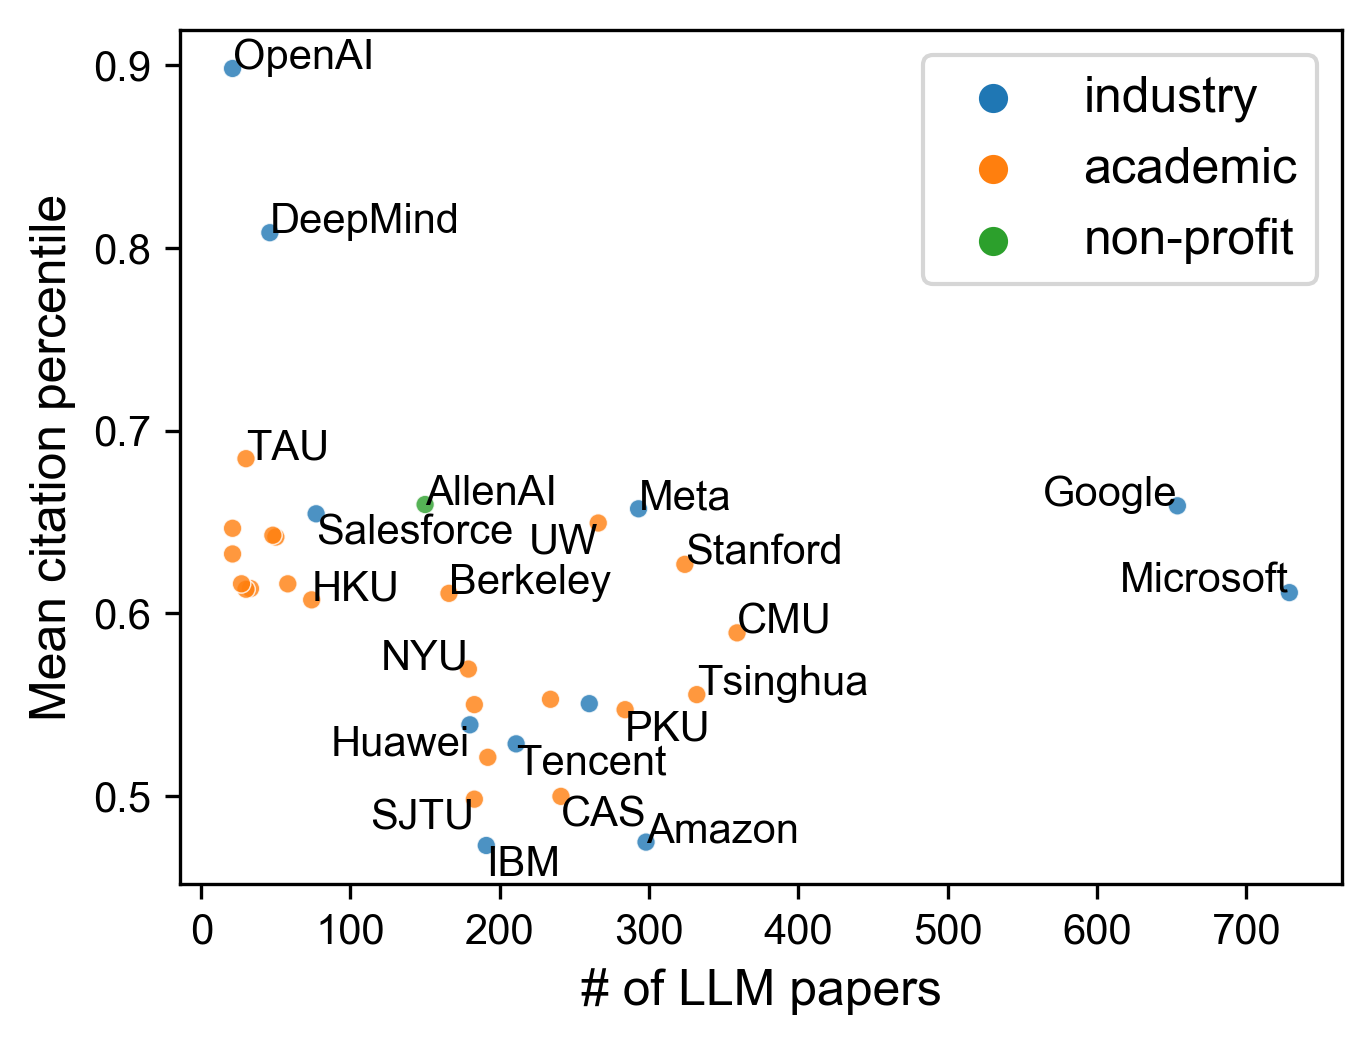

In [23]:
from utils import domain_to_abbreviated_name, domain_to_very_short

# Plot 'count_rank' vs 'total_citations_rank' on a scatterplot for institutions that are in the top 25 for either

top_k = 20

xaxis_col = 'count'
yaxis_col = 'mean_citation_percentile'

institutions_to_include = set(top_domains.sort_values(by=xaxis_col, ascending=False).head(20).domain)
institutions_to_include.update(set(top_domains.sort_values(by=yaxis_col, ascending=False).head(20).domain))
# institutions_to_include = set(top_domains[top_domains.affiliation_type == 'industry'].sort_values(by='count', ascending=False).head(top_k).domain)
print(len(institutions_to_include))

# # Subset institutions_to_include to only include industry domains
# institutions_to_include = set([domain for domain in institutions_to_include if is_industry_domain(domain)])

plot_df = top_domains[top_domains.domain.isin(institutions_to_include)].copy()

plt.figure(figsize=(5, 3.7), dpi=300)

ax = sns.scatterplot(x=xaxis_col, y=yaxis_col, data=plot_df, hue='affiliation_type', alpha=0.8, s=20)

# # Label each point
# # Adjustments for readability - this is for the count in top decile rank
# align_left = ['USTC', 'NTU', 'HKUST', 'Alibaba', 'NYU', 'UIUC', 'Salesforce', 'AllenAI']
# align_bottom = ['HKUST', 'USC', 'Tencent', 'AllenAI']
# # Adjustments for readability - this is for total citation count
include = ['OpenAI', 'DeepMind', 'Google', 'Microsoft', 'Salesforce', 'IBM', 'Meta',
           'Amazon', 'Tencent', 'Huawei',
           'AllenAI', 'NYU',
           'Berkeley', 'Stanford', 'CMU', 'UW',
           'Tsinghua', 'PKU', 'HKU', 'SJTU', 'CAS', 'TAU',
           # 'USC', 'UIUC',
           ]
align_left = ['TTIC', 'SJTU', 'Huawei', 'NYU', 'Microsoft', 'USC', 'UIUC', 'MIT', 'UW', 'Google', '',]
align_bottom = ['PKU', 'IBM', 'SJTU', 'USC', 'Salesforce', 'Tencent', 'CAS', 'Huawei', 'UW', ]
                
for i, row in plot_df.iterrows():
    try:
        abbrev = domain_to_very_short[row['domain']]
    except KeyError:
        abbrev = row['domain']
    if abbrev not in include:
        continue
    ha = 'left'
    va = 'baseline'
    if abbrev in align_left:
        ha = 'right'
    if abbrev in align_bottom:
        va = 'top'
    if abbrev == 'HKUST':
        ha = 'center'
    ax.text(row[xaxis_col], row[yaxis_col], abbrev, fontsize=10, ha=ha, va=va)

# # Draw y = x line
# plt.plot([0, 200], 
#          [0, 200], 
#          color='#888888', linewidth=0.5, linestyle='--')

# Axes should be on log scale, but ticklabels should be on linear scale
# ax.set_xscale('log')
# ax.set_yscale('log')

# # Set ticklabels to be linear, add more tick labels
# ax.set_xticks([20, 50, 100, 200, 500])
# ax.set_xticklabels([20, 50, 100, 200, 500])
# ax.set_yticks([1, 2, 5, 10, 25, 50, 100, 200])
# ax.set_yticklabels([1, 2, 5, 10, 25, 50, 100, 200])

# # Reverse axes so that lower ranks are up and to the right
# ax.set_ylim([0.8, 50])
# ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(ax.get_ylim()[::-1])

# Set axis labels
plt.xlabel('# of LLM papers', fontsize=12)
# plt.ylabel('Rank by # of papers in top 10% of citations', fontsize=12)
plt.ylabel('Mean citation percentile', fontsize=12)

plt.legend(fontsize=12)

plt.savefig('./analysis/figures/affiliation_count_vs_citationpercentile.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()

In [24]:
top_domains[top_domains.affiliation_type == 'industry']

,domain,count,affiliation_type,total_citations,median_citations,median_citation_percentile,mean_citation_percentile,count_above_100_citations,count_in_top_citation_decile,count_rank,total_citations_rank,median_citations_rank,count_above_100_citations_rank,count_in_top_citation_decile_rank
0,microsoft.com,729,industry,36918.000,8.000,0.653,0.611,76,118,1.000,4.000,19.000,2.000,2.000
1,google.com,654,industry,130970.000,14.000,0.732,0.659,116,150,2.000,1.000,7.000,1.000,1.000
5,amazon.com,298,industry,4683.000,5.000,0.476,0.475,10,18,6.000,19.000,50.000,18.000,19.000
6,fb.com,293,industry,42495.000,15.000,0.730,0.657,51,78,7.000,2.000,5.000,3.000,3.000
9,alibaba-inc.com,260,industry,7055.000,6.000,0.554,0.551,11,33,10.000,13.000,38.000,15.000,9.000
12,tencent.com,211,industry,3719.000,4.000,0.498,0.529,8,27,13.000,28.000,81.000,24.000,13.000
14,ibm.com,191,industry,2720.000,5.000,0.476,0.473,5,3,15.000,39.000,50.000,35.000,96.000
17,huawei.com,180,industry,3652.000,4.000,0.544,0.539,6,14,18.000,29.000,81.000,31.000,26.000
51,navercorp.com,80,industry,1311.000,5.000,0.499,0.502,3,6,51.000,68.000,50.000,55.000,63.000
55,salesforce.com,77,industry,3967.000,13.000,0.730,0.654,12,16,56.000,23.000,9.000,14.000,21.000


## Which institutions have changed in publication share in 2023?

In [25]:
# Out of the top 50 most prolific institutions, which ones have changed the most in their publication share in 2023?

domain_count_df_all = utils.get_domain_counts_with_affiliation_type(lm_metadata)

lm_metadata_pre_2023 = lm_metadata[(lm_metadata['v1_date'].dt.year < 2023)].copy()
lm_metadata_2023 = lm_metadata[(lm_metadata['v1_date'].dt.year == 2023)].copy()

domain_count_df_pre_2023 = utils.get_domain_counts_with_affiliation_type(lm_metadata_pre_2023).drop(columns=['affiliation_type'])
domain_count_df_2023 = utils.get_domain_counts_with_affiliation_type(lm_metadata_2023).drop(columns=['affiliation_type'])

count_papers_with_affil_total = len(lm_metadata[(lm_metadata.academic) | (lm_metadata.industry)])
count_papers_with_affil_pre_2023 = len(lm_metadata_pre_2023[(lm_metadata_pre_2023.academic) | (lm_metadata_pre_2023.industry)])
count_papers_with_affil_2023 = len(lm_metadata_2023[(lm_metadata_2023.academic) | (lm_metadata_2023.industry)])

domain_count_df_all['percent_share'] = 100*domain_count_df_all['count'] / count_papers_with_affil_total
domain_count_df_pre_2023['percent_share'] = 100*domain_count_df_pre_2023['count'] / count_papers_with_affil_pre_2023
domain_count_df_2023['percent_share'] = 100*domain_count_df_2023['count'] / count_papers_with_affil_2023

# Merge all 3 dataframes on domain, with suffixes _all, _pre_2023, _2023
domain_count_df_merged = domain_count_df_pre_2023.merge(domain_count_df_2023, on='domain', suffixes=('_pre_2023', '_2023'))
domain_count_df_merged = domain_count_df_merged.merge(domain_count_df_all, on='domain', suffixes=('_pre_2023', '_all'))
domain_count_df_merged = domain_count_df_merged.rename(columns={'count': 'count_all', 'percent_share': 'percent_share_all'})

# Add p-value comparing (# institution in 2023) / (total papers in 2023) to (# institution pre 2023) / (total papers pre 2023)
# Use chi2 test: stats.chi2_contingency([[a, b], [c, d]])
domain_count_df_merged['p_value'] = domain_count_df_merged.apply(lambda row: 
                                                                 stats.chi2_contingency([[row['count_pre_2023'], 
                                                                                          count_papers_with_affil_pre_2023 - row['count_pre_2023']], 
                                                                                          [row['count_2023'], 
                                                                                           count_papers_with_affil_2023 - row['count_2023']]])[1], axis=1)


# Only retain domains with at least 20 papers total
min_papers = 20
domain_count_df_merged = domain_count_df_merged[domain_count_df_merged['count_all'] >= min_papers]

print(f"Number of domains with at least {min_papers} papers total:", len(domain_count_df_merged))
display(domain_count_df_merged.head())

# print Spearman correlation between count before 2023 and count in 2023
from scipy.stats import spearmanr
print('Spearman(count pre 2023, count in 2023):', spearmanr(domain_count_df_merged['count_pre_2023'], domain_count_df_merged['count_2023']))

Number of domains with at least 20 papers total: 209


,domain,count_pre_2023,percent_share_pre_2023,count_2023,percent_share_2023,count_all,affiliation_type,percent_share_all,p_value
0,microsoft.com,499,6.731,230,5.380,729,industry,6.237,0.004
1,google.com,491,6.623,163,3.813,654,industry,5.595,0.000
2,cmu.edu,234,3.157,125,2.924,359,academic,3.072,0.518
3,amazon.com,219,2.954,79,1.848,298,industry,2.550,0.000
4,fb.com,213,2.873,80,1.871,293,industry,2.507,0.001


Spearman(count pre 2023, count in 2023): SignificanceResult(statistic=0.6678331687261486, pvalue=2.340917890370609e-28)


In [26]:
# Compute log2(count_2023 / count_pre_2023) for each domain, and sort by value
# domain_count_df_merged['log2_ratio'] = np.log2(domain_count_df_merged['percent_share_2023'] / domain_count_df_merged['percent_share_pre_2023'])
# domain_count_df_merged = domain_count_df_merged.sort_values(by='log2_ratio', ascending=False)
domain_count_df_merged['pct_diff'] = domain_count_df_merged['percent_share_2023'] - domain_count_df_merged['percent_share_pre_2023']
domain_count_df_merged = domain_count_df_merged.sort_values(by='pct_diff', ascending=False)

# Display head and tail
print_cols = ['domain', 'percent_share_pre_2023', 'percent_share_2023',
              'count_pre_2023', 'count_2023', 
              'pct_diff',
              'p_value',
            #   'log2_ratio',
            ]

industry_results = domain_count_df_merged[domain_count_df_merged['affiliation_type'] == 'industry']
academic_results = domain_count_df_merged[domain_count_df_merged['affiliation_type'] == 'academic']

print("Companies with largest increase in publication share:")
display(industry_results.head(10)[print_cols])

print("Companies with largest decrease in publication share:")
display(industry_results.tail(10)[print_cols])

print("Academic institutions with largest increase in publication share:")
display(academic_results.head(10)[print_cols])

print("Academic institutions with largest decrease in publication share:")
display(academic_results.tail(10)[print_cols])

Companies with largest increase in publication share:


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
68,adobe.com,0.499,0.936,37,40,0.437,0.007
64,bytedance.com,0.540,0.842,40,36,0.303,0.066
12,tencent.com,1.781,1.848,132,79,0.067,0.848
156,meituan.com,0.243,0.281,18,12,0.038,0.841
131,qq.com,0.270,0.304,20,13,0.034,0.876
164,bosch.com,0.229,0.257,17,11,0.028,0.919
214,sensetime.com,0.162,0.187,12,8,0.025,0.932
206,antgroup.com,0.175,0.164,13,7,-0.012,1.000
136,yahoo.com,0.270,0.187,20,8,-0.083,0.494
96,apple.com,0.364,0.281,27,12,-0.084,0.557


Companies with largest decrease in publication share:


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
63,samsung.com,0.540,0.257,40,11,-0.282,0.037
70,deepmind.com,0.499,0.211,37,9,-0.289,0.025
54,nvidia.com,0.648,0.327,48,14,-0.320,0.031
41,salesforce.com,0.796,0.421,59,18,-0.375,0.022
47,baidu.com,0.715,0.304,53,13,-0.411,0.006
11,ibm.com,1.875,1.216,139,52,-0.659,0.009
4,fb.com,2.873,1.871,213,80,-1.002,0.001
3,amazon.com,2.954,1.848,219,79,-1.106,0.000
0,microsoft.com,6.731,5.380,499,230,-1.351,0.004
1,google.com,6.623,3.813,491,163,-2.811,0.000


Academic institutions with largest increase in publication share:


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
31,zju.edu.cn,0.944,2.105,70,90,1.161,0.000
39,ntu.edu.sg,0.836,1.918,62,82,1.082,0.000
57,cuhk.edu,0.648,1.684,48,72,1.037,0.000
13,ac.cn,1.713,2.667,127,114,0.953,0.001
40,nus.edu.sg,0.796,1.614,59,69,0.818,0.000
9,pku.edu.cn,2.212,2.807,164,120,0.595,0.051
333,mbzuai.ac.ae,0.081,0.632,6,27,0.551,0.000
19,sjtu.edu.cn,1.376,1.895,102,81,0.519,0.036
75,hku.hk,0.445,0.959,33,41,0.514,0.001
157,pjlab.org.cn,0.243,0.749,18,32,0.506,0.000


Academic institutions with largest decrease in publication share:


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
15,nyu.edu,1.619,1.380,120,59,-0.239,0.350
116,ims.uni-stuttgart.de,0.310,0.070,23,3,-0.240,0.014
78,ufal.mff.cuni.cz,0.432,0.187,32,8,-0.245,0.044
59,ubc.ca,0.634,0.351,47,15,-0.283,0.058
79,rwth-aachen.de,0.418,0.117,31,5,-0.301,0.008
55,di.ku.dk,0.648,0.281,48,12,-0.367,0.011
52,ntu.edu.tw,0.661,0.281,49,12,-0.380,0.009
53,unc.edu,0.648,0.234,48,10,-0.414,0.003
24,jhu.edu,1.160,0.468,86,20,-0.692,0.000
7,washington.edu,2.590,1.731,192,74,-0.859,0.003


In [27]:
# Display top 10 domains sorted by abs(pct_diff)
print("Top 10 domains sorted by abs(pct_diff):")
display(domain_count_df_merged.head(10)[print_cols])
display(domain_count_df_merged.tail(10)[print_cols])

big_tech = ['google.com', 'microsoft.com', 'amazon.com', 'fb.com']
# Print sum(percent_share_pre_2023) and sum(percent_share_2023) for big tech
print("Big tech sum(percent_share_pre_2023):", domain_count_df_merged[domain_count_df_merged['domain'].isin(big_tech)]['percent_share_pre_2023'].sum())
print("Big tech sum(percent_share_2023):", domain_count_df_merged[domain_count_df_merged['domain'].isin(big_tech)]['percent_share_2023'].sum())

# Print sum(percent_share_pre_2023) and sum(percent_share_2023) for top_10_chinese_institution_domains
# from utils import top_10_chinese_institution_domains
top_asian_institution_domains = domain_count_df_merged.head(10).domain.values
print("Top 10 Chinese institution domains sum(percent_share_pre_2023):", domain_count_df_merged[domain_count_df_merged['domain'].isin(top_asian_institution_domains)]['percent_share_pre_2023'].sum())
print("Top 10 Chinese institution domains sum(percent_share_2023):", domain_count_df_merged[domain_count_df_merged['domain'].isin(top_asian_institution_domains)]['percent_share_2023'].sum())

Top 10 domains sorted by abs(pct_diff):


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
31,zju.edu.cn,0.944,2.105,70,90,1.161,0.000
39,ntu.edu.sg,0.836,1.918,62,82,1.082,0.000
57,cuhk.edu,0.648,1.684,48,72,1.037,0.000
13,ac.cn,1.713,2.667,127,114,0.953,0.001
40,nus.edu.sg,0.796,1.614,59,69,0.818,0.000
9,pku.edu.cn,2.212,2.807,164,120,0.595,0.051
333,mbzuai.ac.ae,0.081,0.632,6,27,0.551,0.000
19,sjtu.edu.cn,1.376,1.895,102,81,0.519,0.036
75,hku.hk,0.445,0.959,33,41,0.514,0.001
157,pjlab.org.cn,0.243,0.749,18,32,0.506,0.000


,domain,percent_share_pre_2023,percent_share_2023,count_pre_2023,count_2023,pct_diff,p_value
47,baidu.com,0.715,0.304,53,13,-0.411,0.006
53,unc.edu,0.648,0.234,48,10,-0.414,0.003
11,ibm.com,1.875,1.216,139,52,-0.659,0.009
24,jhu.edu,1.160,0.468,86,20,-0.692,0.000
17,allenai.org,1.592,0.749,118,32,-0.843,0.000
7,washington.edu,2.590,1.731,192,74,-0.859,0.003
4,fb.com,2.873,1.871,213,80,-1.002,0.001
3,amazon.com,2.954,1.848,219,79,-1.106,0.000
0,microsoft.com,6.731,5.380,499,230,-1.351,0.004
1,google.com,6.623,3.813,491,163,-2.811,0.000


Big tech sum(percent_share_pre_2023): 19.182517199514365
Big tech sum(percent_share_2023): 12.912280701754385
Top 10 Chinese institution domains sum(percent_share_pre_2023): 9.294482665587482
Top 10 Chinese institution domains sum(percent_share_2023): 17.02923976608187


In [28]:
# Print a LaTeX table of the top 5 domains with largest increase + 5 domains with largest decrease

latex_df = domain_count_df_merged.head(5).append(domain_count_df_merged.tail(5).sort_values(by='pct_diff')).copy()

# Print out a latex table of the subarxiv counts
latex_df = latex_df[['domain',
                     'percent_share_pre_2023',
                     'percent_share_2023',
                    #  'pct_diff', 
                    #  'p_value',
                    ]].copy()

latex_df['pct_change'] = 100*(latex_df['percent_share_2023'] - latex_df['percent_share_pre_2023']) / latex_df['percent_share_pre_2023']

# Convert table to latex
# Use different float format for each column
float_format = {'percent_share_pre_2023': '{:,.1f}%'.format,
                'percent_share_2023': '{:,.1f}%'.format,
                'domain': lambda x: domain_to_abbreviated_name[x],
                # 'pct_diff': '{:.1f}'.format,
                'pct_change': '{:.0f}'.format,
                # 'p_value': '{:.1e}'.format,
                }

# Apply string formatting to each column
formatted_df = latex_df.copy()
for column, format_spec in float_format.items():
    formatted_df[column] = formatted_df[column].apply(format_spec)

formatted_df = formatted_df.rename(columns={
                                    'domain': 'Institution', 
                                    'percent_share_pre_2023': 'pre-2023',
                                    'percent_share_2023': '2023',
                                    # 'pct_diff': 'Delta',
                                    'pct_change': 'Delta',
                                    })

# Convert the formatted DataFrame to LaTeX
# Use styler
latex_table = formatted_df.to_latex(index=False, escape=True, column_format='lccc', bold_rows=True)
print(latex_table)

\begin{tabular}{lccc}
\toprule
            Institution & pre-2023 & 2023 & Delta \\
\midrule
               Zhejiang &     0.9\% & 2.1\% &   123 \\
          NTU Singapore &     0.8\% & 1.9\% &   129 \\
Chinese U. of Hong Kong &     0.6\% & 1.7\% &   160 \\
Chinese Academy of Sci. &     1.7\% & 2.7\% &    56 \\
                    NUS &     0.8\% & 1.6\% &   103 \\
                 Google &     6.6\% & 3.8\% &   -42 \\
              Microsoft &     6.7\% & 5.4\% &   -20 \\
                 Amazon &     3.0\% & 1.8\% &   -37 \\
                   Meta &     2.9\% & 1.9\% &   -35 \\
                     UW &     2.6\% & 1.7\% &   -33 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2737807/712193022.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = domain_count_df_merged.head(5).append(domain_count_df_merged.tail(5).sort_values(by='pct_diff')).copy()
/tmp/ipykernel_2737807/712193022.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = formatted_df.to_latex(index=False, escape=True, column_format='lccc', bold_rows=True)


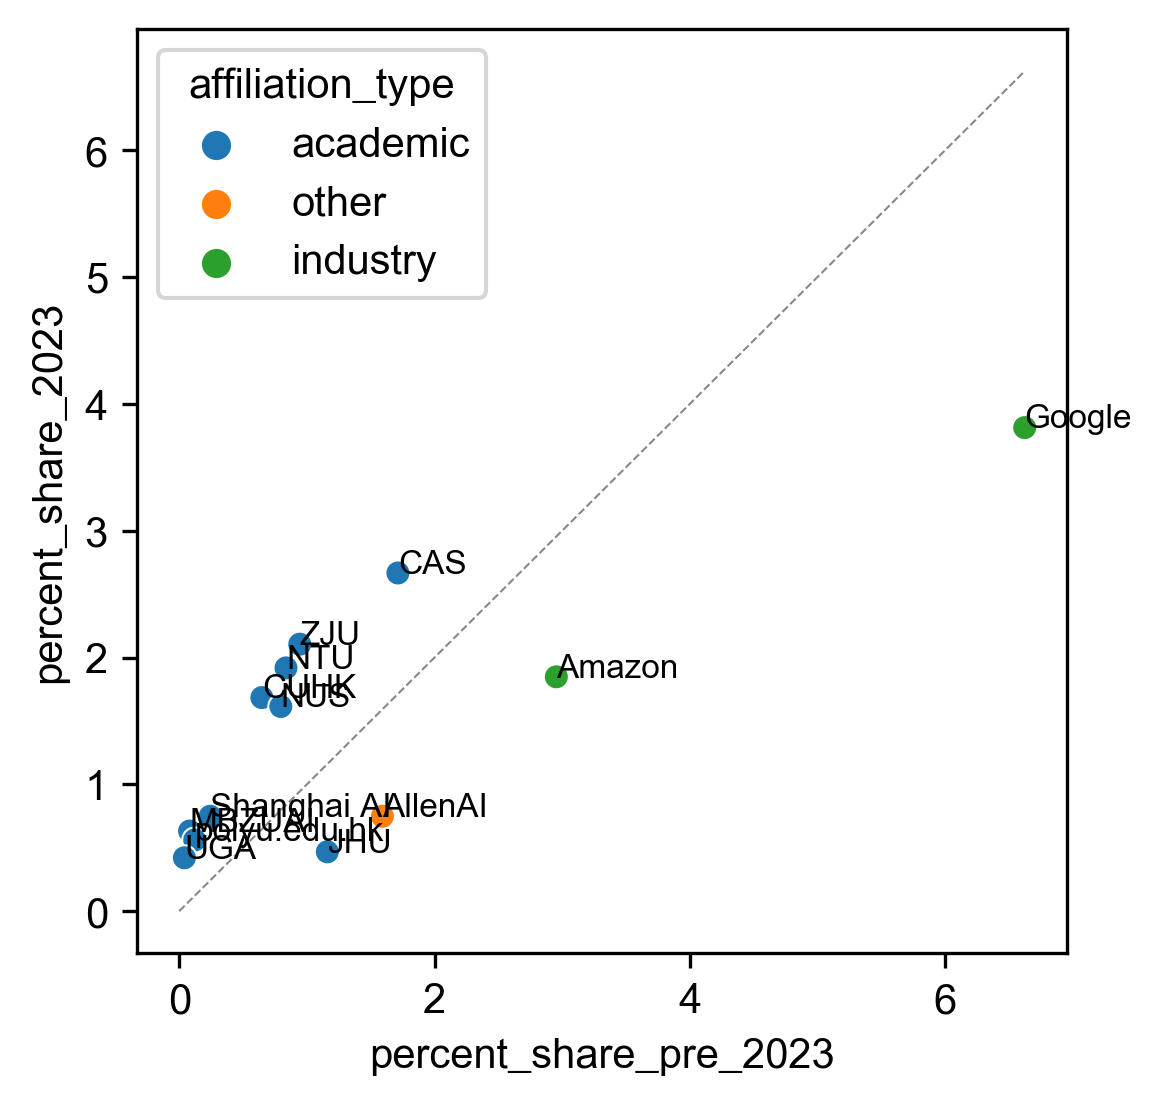

In [29]:
from utils import domain_to_very_short

# Plot scatterplot of percent share in 2023 vs percent share pre-2023 for the top 25 domains by count
top_k = 10

xaxis_col = 'percent_share_pre_2023'
yaxis_col = 'percent_share_2023'
# xaxis_col = 'count_pre_2023'
# yaxis_col = 'count_2023'

institutions_to_include = set(domain_count_df_merged[domain_count_df_merged.p_value < 1e-3].domain)

# Remove microsoft, google

plot_df = domain_count_df_merged[domain_count_df_merged.domain.isin(institutions_to_include)].copy()

plt.figure(figsize=(4, 4), dpi=300)

ax = sns.scatterplot(x=xaxis_col, y=yaxis_col, data=plot_df, hue='affiliation_type')
# sns.regplot(x=xaxis_col, y=yaxis_col, data=plot_df, scatter=False, ax=ax)

for i, row in plot_df.iterrows():
    try:
        abbrev = domain_to_very_short[row['domain']]
    except KeyError:
        abbrev = row['domain']
    ha = 'left'
    va = 'baseline'
    ax.text(row[xaxis_col], row[yaxis_col], abbrev, fontsize=8, ha=ha, va=va)

# Draw y = x line
# Get max value for x and y axes
max_val = max(plot_df[xaxis_col].max(), plot_df[yaxis_col].max())
# expected_slope = domain_count_df_merged[yaxis_col].sum() / domain_count_df_merged[xaxis_col].sum()
plt.plot([0, max_val], 
         [0, max_val], 
         color='#888888', linewidth=0.5, linestyle='--')

plt.show()



## Collaboration network

In [30]:
from itertools import combinations

# Given a df with a 'domains' column, return a list of vertices and a corresponding adjacency matrix,
# where the weight between two nodes is equal to the number of papers 

def get_weighted_adj_matrix(df, top_n_institutions=10):
    domain_count_df = utils.get_domain_counts_with_affiliation_type(df)
    if top_n_institutions is None:
        top_n_institutions = len(domain_count_df)
    top_domains = domain_count_df.head(top_n_institutions)['domain'].tolist()
    top_domain_counts = domain_count_df.head(top_n_institutions)['count'].tolist()

    vertices = []
    counts = []    
    for i in range(len(top_domains)):
        vertices.append(top_domains[i])
        counts.append(top_domain_counts[i])
    
    adj_matrix = np.zeros((len(vertices), len(vertices)))
    for domains in df['domains']:
        for domain_1, domain_2 in combinations(domains, 2):
            if domain_1 not in vertices or domain_2 not in vertices:
                continue
            i = vertices.index(domain_1)
            j = vertices.index(domain_2)
            adj_matrix[i][j] += 1
            adj_matrix[j][i] += 1
            
    return vertices, counts, adj_matrix

# A list of vertices (domain names) and an adjacency matrix A, return the weight between domain_1 and domain_2
def get_weight(vertices, A, domain_1, domain_2):
    return A[vertices.index(domain_1)][vertices.index(domain_2)]

In [31]:
V, counts, A = get_weighted_adj_matrix(lm_metadata, top_n_institutions=20)

edges = []
for i in range(len(V)):
    for j in range(i + 1, len(V)):
        edges.append((V[i], V[j], A[i][j]))

print("Total number of edges:", len(edges))
print("Total number of collaborations:", sum([edge[2] for edge in edges]))

# Print all domains
for i in range(len(V)):
    print(V[i], counts[i])

# k_papers_to_count_collaboration = 1
# count_of_collabs_above_k = 0
# look_for_edges_with = 'illinois.edu'

# edges.sort(key=lambda x: x[2], reverse=True)
# for edge in edges:
#     if (edge[0] == look_for_edges_with or edge[1] == look_for_edges_with) and edge[2] >= k_papers_to_count_collaboration:
#         print(edge)
#     if edge[2] >= k_papers_to_count_collaboration:
#         count_of_collabs_above_k += 1

# print("Total number of collaborations with at least", k_papers_to_count_collaboration, "papers:", count_of_collabs_above_k)

Total number of edges: 190
Total number of collaborations: 846.0
microsoft.com 729
google.com 654
cmu.edu 359
tsinghua.edu.cn 332
stanford.edu 324
amazon.com 298
fb.com 293
pku.edu.cn 284
washington.edu 266
alibaba-inc.com 260
ac.cn 241
mit.edu 234
tencent.com 211
usc.edu 192
ibm.com 191
illinois.edu 183
sjtu.edu.cn 183
huawei.com 180
nyu.edu 179
berkeley.edu 166


In [32]:
top_US_institutions = [
    'microsoft.com',
    'google.com',
    'cmu.edu',
    'stanford.edu',
    'amazon.com',
    'fb.com',
    'washington.edu',
    'mit.edu',
    'usc.edu',
    'ibm.com',
    'illinois.edu',
    'nyu.edu',
    'berkeley.edu',
]

top_CN_institutions = [
    'tsinghua.edu.cn',
    'pku.edu.cn',
    'alibaba-inc.com',
    'ac.cn',
    'tencent.com',
    'sjtu.edu.cn',
    'huawei.com',
]

print(f"# US institutions: {len(top_US_institutions)}, # CN institutions: {len(top_CN_institutions)}")

# Count US-US collaborations
count_US_US_collabs = 0
for edge in edges:
    if edge[0] in top_US_institutions and edge[1] in top_US_institutions:
        count_US_US_collabs += edge[2]
print("Total number of US-US collaborations:", count_US_US_collabs)

# Count CN-CN collaborations
count_CN_CN_collabs = 0
for edge in edges:
    if edge[0] in top_CN_institutions and edge[1] in top_CN_institutions:
        count_CN_CN_collabs += edge[2]
print("Total number of CN-CN collaborations:", count_CN_CN_collabs)

# Count US-CN collaborations
count_US_CN_collabs_microsoft = 0
count_US_CN_collabs_other = 0
for edge in edges:
    if edge[0] in top_US_institutions and edge[1] in top_CN_institutions and (edge[0] == 'microsoft.com' or edge[1] == 'microsoft.com'):
        count_US_CN_collabs_microsoft += edge[2]
    elif edge[0] in top_CN_institutions and edge[1] in top_US_institutions and (edge[0] == 'microsoft.com' or edge[1] == 'microsoft.com'):
        count_US_CN_collabs_microsoft += edge[2]
    elif edge[0] in top_US_institutions and edge[1] in top_CN_institutions:
        # if edge[2] > 0:
        #     print(edge)
        count_US_CN_collabs_other += edge[2]
    elif edge[0] in top_CN_institutions and edge[1] in top_US_institutions:
        # if edge[2] > 0:
        #     print(edge)
        count_US_CN_collabs_other += edge[2]
print("Total number of US-CN collaborations involving Microsoft:", count_US_CN_collabs_microsoft)
print("Total number of US-CN collaborations not involving Microsoft:", count_US_CN_collabs_other)

# US institutions: 13, # CN institutions: 7
Total number of US-US collaborations: 482.0
Total number of CN-CN collaborations: 162.0
Total number of US-CN collaborations involving Microsoft: 105.0
Total number of US-CN collaborations not involving Microsoft: 97.0
